# QP 2 Computational Lab

## Starter Code for Part 1

The following cells are to set up your environment, if needed:

In [37]:
pip install numpy opencv-python scikit-image matplotlib torch torchvision torchsummary albumentations cellpose captum

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import sys
import torch
import cv2
import albumentations as A
import skimage
import cellpose
from torchsummary import summary

def check_env():
    print("--- Quantitative Physiology Lab: Environment Check ---")
    
    # 1. Check Python Version
    print(f"Python Version: {sys.version.split()[0]} - {'OK' if sys.version_info >= (3,8) else 'UPDATE NEEDED'}")

    # 2. Check GPU Availability (Crucial for Week 3 & 5)
    gpu_available = torch.cuda.is_available()
    print(f"PyTorch GPU Acceleration: {'ENABLED (' + torch.cuda.get_device_name(0) + ')' if gpu_available else 'DISABLED (CPU Only)'}")
    if not gpu_available:
        print("   NOTE: Training will be significantly slower without a GPU.")

    # 3. Check Image Processing Libraries
    try:
        test_img = (torch.rand(1, 1, 256, 256) * 255).numpy().astype('uint8')[0,0]
        # Test OpenCV CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        _ = clahe.apply(test_img)
        # Test Scikit-Image
        _ = skimage.measure.label(test_img)
        print("Image Processing Libraries (OpenCV/Skimage): OK")
    except Exception as e:
        print(f"Image Processing Libraries: FAILED - {e}")

    # 4. Check CellPose API
    try:
        from cellpose import models
        _ = models.CellposeModel(gpu=gpu_available, model_type='cyto2')
        print("CellPose API: OK")
    except Exception as e:
        print(f"CellPose Check: FAILED - {e}")

    # 5. Check Albumentations
    print(f"Albumentations Version: {A.__version__} - OK")

if __name__ == "__main__":
    check_env()

model_type argument is not used in v4.0.1+. Ignoring this argument...


--- Quantitative Physiology Lab: Environment Check ---
Python Version: 3.13.5 - OK
PyTorch GPU Acceleration: DISABLED (CPU Only)
   NOTE: Training will be significantly slower without a GPU.
Image Processing Libraries (OpenCV/Skimage): OK
CellPose API: OK
Albumentations Version: 2.0.8 - OK


## Load a single image file

Once your environment is correctly set up, choose one image from dominant_follicle set, load it as grayscale,  convert it to type float, and normalize to values between [0,1], using the starter code provided.  (JPG files are generally stored as 3-channel RGB files, even if the ultrasound looks black and white.  We load as grayscale to avoid doing calculations on three identical channels, which triples the memory usage for no reason.)

In [39]:
import cv2
import numpy as np

def load_and_prep_ultrasound(path):
    # 1. Load as grayscale even if the file is RGB
    raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # 2. Check for empty file BEFORE operating on raw
    if raw is None:
        raise FileNotFoundError("Check your file path!")

    raw = raw.astype(float) / 255.0
    
    return raw



Shape after float conversion: (256, 256)
Dtype after float conversion: float64


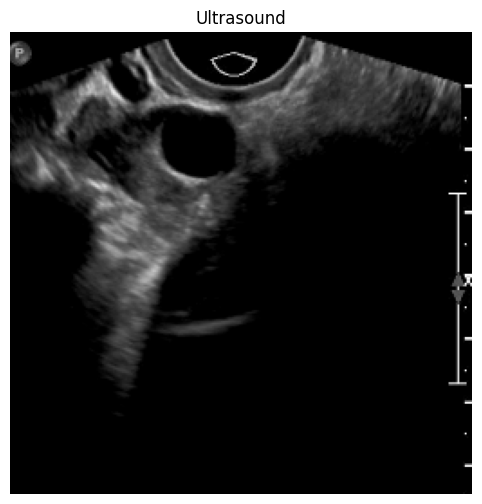

In [40]:
import matplotlib.pyplot as plt

loaded_image = load_and_prep_ultrasound("dominant_follicle_0003.png")
print(f"Shape after float conversion: {loaded_image.shape}")
print(f"Dtype after float conversion: {loaded_image.dtype}")

plt.figure(figsize=(8, 6))
plt.imshow(loaded_image, cmap='gray')
plt.title('Ultrasound')
plt.axis('off')
plt.show()

## Filtering out Speckle Noise

Time to deal with the Speckle. 

We might use a standard Gaussian blur, but that often "smears" the edges of the follicle, which is problematic for measurement. Instead, use a Median Filter. It is effective at removing salt-and-pepper noise while preserving the sharp edges of the follicle wall.  Apply your Median Filter here, using cv2.medianBlur( ).  

As the argument to the filter function, choose an appropriate kernel size for the noise level of your image. Kernel size must be an odd positive integer. (Hint: If the goal is to remove sparse, high-contrast "salt-and-pepper" noise, even a small kernel like 3x3 or 5x5 is highly effective. A larger kernel will blur the image more, so you should use the smallest size that effectively removes the noise you are targeting.)



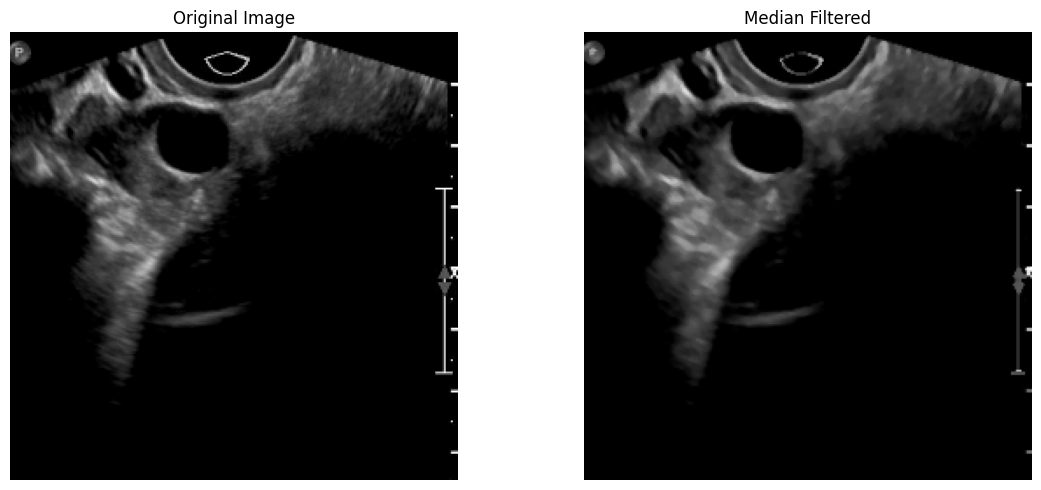

In [41]:

# Convert float image to uint8 for median blur
loaded_image_uint8 = (loaded_image * 255).astype(np.uint8)

spec_filt_out = cv2.medianBlur(loaded_image_uint8, 3)

# Display images using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(loaded_image_uint8, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(spec_filt_out, cmap='gray')
axes[1].set_title('Median Filtered')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Apply CLAHE

Standard histogram equalization often over-amplifies noise. We will implement Contrast Limited Adaptive Histogram Equalization (CLAHE). CLAHE is advanced image processing technique that enhances local contrast by breaking images into small tiles (e.g., 8x8) and applying histogram equalization to each. 

You must choose parameters for the clip limit and tile grid size. 

The clip limit is a threshold for contrast amplification. Histograms in each tile are clipped at this limit to prevent noise over-amplification in relatively homogeneous regions of the image.

Common effective values for the clip limit often fall within the range of 2 to 5. Values of 3 to 4 are frequently cited as generally effective.

Lower clip limits (closer to 1) reduce noise but may result in insufficient contrast enhancement, producing an image closer to the original.

Higher clip limits (e.g., in the range of 40 in some OpenCV implementations, or very large values) increase contrast but can also amplify noise.

The optimal clip limit interacts with the tile grid size parameter. Experiment with both to achieve the desired results. The tile size should ideally be larger than the size of features you wish to preserve. 

CLAHE therefore limits contrast enhancement, specifically preventing noise amplification in homogeneous areas. Apply CHAHE to your filtered image using cv2.createCLAHE( ) with an appropriate clip limit and tile grid size: 

In [44]:
clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize=(8,8))
img_clahe = clahe.apply(spec_filt_out)


Here is some code for you to visualize your images. Experiment with different arguments in your median filter and CLAHE enhancement until you have what you believe to be the 'best' pre-processing.

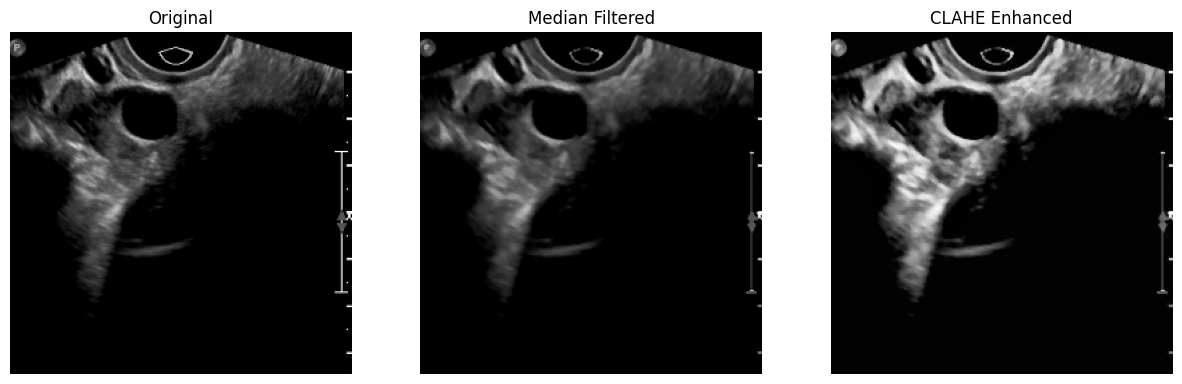

In [45]:
titles = ['Original', 'Median Filtered', 'CLAHE Enhanced']
images = [loaded_image, spec_filt_out, img_clahe] # replace with your image variable names
    
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

## Determine outcomes of pre-processing

We will now quantify the efficacy of our pre-processing steps by calculating the CNR, or Contrast-to-Noise Ratio, for our raw image, median filtered image, and median+CLAHE image. 

Use 

$CNR = \frac{|\mu_f-\mu_s|}{\sqrt{{\sigma_f}^2+{\sigma_s}^2}}$

where $\mu_f$ and $\mu_s$ are the mean of the follicle and stroma regions of interest, and $\sigma_f$ and $\sigma_s$ are the standard deviations of the follicle and stroma regions of interest. 

Reminder: the follicle is a dark circular region on the image, and the stroma is the brighter, relatively homogenous connective tissue that surrounds the follicles. 

Here is some starter code that allows you to choose the ROI for the follicle and the stroma of an image. Use the *same ROI* for your calculations of CNR for your raw, median-filtered, and median+CLAHE images.

In [64]:

# Custom ellipse selector
def select_ellipse(window_name, image):
    clone = image.copy()
    drawing = False
    start = (0, 0)
    end = (0, 0)

    def mouse_callback(event, x, y, flags, param):
        nonlocal drawing, start, end, clone

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            start = (x, y)

        elif event == cv2.EVENT_MOUSEMOVE and drawing:
            clone = image.copy()
            cv2.ellipse(clone, 
                        ((start[0]+x)//2, (start[1]+y)//2),  # center
                        (abs(x-start[0])//2, abs(y-start[1])//2),  # axes
                        0, 0, 360, 1.0, 2)
            end = (x, y)

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            end = (x, y)

    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, mouse_callback)

    while True:
        cv2.imshow(window_name, clone)
        if cv2.waitKey(1) & 0xFF == 13:  # ENTER to confirm
            break

    cv2.destroyWindow(window_name)

    # Return roi as (x, y, w, h) same format as selectROI
    x = min(start[0], end[0])
    y = min(start[1], end[1])
    w = abs(end[0] - start[0])
    h = abs(end[1] - start[1])
    return (x, y, w, h)

def extract_ellipse(image, roi):
    x, y, w, h = int(roi[0]), int(roi[1]), int(roi[2]), int(roi[3])
    crop = image[y:y+h, x:x+w]
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.ellipse(mask, (w//2, h//2), (w//2, h//2), 0, 0, 360, 255, -1)
    return crop[mask == 255]

# 1. Select Follicle ROI
print("Draw Follicle ellipse, then press ENTER.")
roi_f = select_ellipse("Select Follicle", img_clahe)

# 2. Select Stroma ROI
print("Draw Stroma ellipse, then press ENTER.")
roi_s = select_ellipse("Select Stroma", img_clahe)

# 3. Extract Data
f_data = extract_ellipse(img_clahe, roi_f)
s_data = extract_ellipse(img_clahe, roi_s)
print(f"Follicle pixel count: {f_data.shape[0]}, Stroma pixel count: {s_data.shape[0]}")



f_mu = np.mean(f_data)
f_sigma = np.std(f_data)

s_mu = np.mean(s_data)
s_sigma = np.std(s_data)


cnr = abs(f_mu-s_mu)/((s_sigma)**2+(f_sigma)**2)**0.5
print(cnr)


Draw Follicle ellipse, then press ENTER.
Draw Stroma ellipse, then press ENTER.
Follicle pixel count: 603, Stroma pixel count: 2610
0.8427842322467469


In [65]:
f_mu = np.mean(f_data)
f_sigma = np.std(f_data)

s_mu = np.mean(s_data)
s_sigma = np.std(s_data)

Using the formula given above, calculate the CNR for your three images. When you are done, return to the lab manual for report instructions.

In [66]:
cnr = abs(f_mu-s_mu)/((s_sigma)**2+(f_sigma)**2)**0.5
print(cnr)

0.8427842322467469
